### Model 3 - Linear Regression of Country-wise factors

The goal of this third bundle of models is to examine the correlation between total number of medals won by a country and some its characteristics. In this analysis we will consider each country's gross domestic product (GDP), human development index (HDI) and total population for each year the country competed in the Olympic Games.

To investigate this problem we will employ some linear regression models. Towards the end we will also implement a logistic regression model and compare its results with those of the corresponding linear regression.

As usual, we start off by importing everything that will be needed going forward.

In [1]:
import pandas as pd
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.special import expit

### Cleaning the dataset

Before implementing the models, there is a lot of cleaning up we need to do. We start by importing our main dataset and visualising it.

In [2]:
initial_df = pd.read_csv('data/athlete_events.csv', index_col='ID') 
initial_df.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


The team names in this dataset do not always correspond to the country name, as we can clearly see in row 4. For this reason we use a second dataframe, which has the NOC values and the corresponding country names. So we import this dataframe and merge the two together.

In [3]:
regions_df = pd.read_csv('data/noc_regions.csv')
regions_df.columns = ['NOC','Country','notes']
# Replace NOC SGP with SIN (Singapore appears with SGP and SIN, but we consider them both to be the same region)
initial_df["NOC"].replace({"SGP": "SIN"}, inplace=True)
initial_df = initial_df.merge(regions_df[['NOC', 'Country']], left_on = 'NOC',
                       right_on = 'NOC', how = 'left')

This dataset is focused on the athletes, whereas our analysis is focused on the countries.  
Naturally, we will not be needing all of these columns for our analysis, since we will be focusing on the countries as a whole rather than the single athletes. Also some over specific information about the specific olympic games, such as the city in which they took place, are irrelevant for our analysis. For these reasons, we drop some columns from our dataframe.

In [4]:
columns = ["Name","Sex","Age","Height","Weight","Games","City","Sport","Season","Team"]
initial_df.drop(columns, inplace=True, axis=1)

For future merging (of the dictionary) we will need to add another column, which displays the combination of Country and Year.

In [5]:
Country_Year = [(str(initial_df['Country'][i])+' '+str(initial_df['Year'][i])) for i,row in initial_df.iterrows()]
initial_df['Country_Year'] = Country_Year

Since a lot of data are missing before 1960, we delete every row with Year<1960.

In [6]:
initial_df = initial_df[initial_df['Year']>1959].reset_index()

Our first goal for this part is to check whether the number of total medals won by a country is affected (?) by its GDP, population size and HDI. For this reason we only include in the dataframe countries that have won a medal in a given olympic game.

In [7]:
medal = ["Gold","Silver","Bronze"]
initial_df = initial_df[initial_df['Medal'].isin(medal)]
initial_df = initial_df.dropna(subset=["NOC","Medal"])
initial_df.head(3)

,index,NOC,Year,Event,Medal,Country,Country_Year
30,40,FIN,2014,Ice Hockey Men's Ice Hockey,Bronze,Finland,Finland 2014
33,60,NOR,1992,Alpine Skiing Men's Super G,Gold,Norway,Norway 1992
34,61,NOR,1992,Alpine Skiing Men's Giant Slalom,Bronze,Norway,Norway 1992


Next, we check the total number of medals won by each country per year. To do this we first create a dictionary with the needed information and then convert it into a dataframe. We also compile a second dictionary to keep track of those events which award more than one medal per winner, for example synchronised diving. This way, in the final dataframe we will only account for one medal per event per winning country, rather than multiple ones.

In [8]:
medals_per_year = {}
avoid_group_sports = {}
n=0
for i,row in initial_df.iterrows():
    y = int(initial_df['Year'][i])
    s = str(initial_df['Country_Year'][i])
    e = str(initial_df['Event'][i]+' '+s)
    if e not in avoid_group_sports:
        avoid_group_sports[e] = 1
        if s not in medals_per_year:
            medals_per_year[s] = 1
        else:
            medals_per_year[s] +=1
    else:
        avoid_group_sports[e] += 1

In [9]:
print(len(medals_per_year),len(avoid_group_sports),len(initial_df))

1062 12338 28400


As can be seen from the print above, the lengths of the three datasets are very different:
- 28,400 are the athletes that have compited in the olympics and won a medal since 1960
- 12,338 are the events in which medals have been won throughout the years
- 1,062 are the countries that have compited in the olympics, each country is counted multiple times depending on the year

Finally, we initialise a new dataset, which keeps count of the amount of medals won by each country in a year. "mpy" stands for "medals per year".

In [10]:
mpy = pd.DataFrame(medals_per_year.items())
mpy.columns = ['Country_Year','Medals_won']

Lastly, to make it easier to match up the other datasets, we add two other columns to our dataset.

In [11]:
countries = []
years = []
for i,row in mpy.iterrows():
    try:
        c,y = mpy['Country_Year'][i].split()
    except:
        try:
            c1,c2,y = mpy['Country_Year'][i].split()
            c=str(c1+' '+c2)
        except:
            c1,c2,c3,y = mpy['Country_Year'][i].split()
            c=str(c1+' '+c2+' '+c3)
    countries.append(c)
    years.append(y)

In [12]:
mpy['Country'] = countries
mpy['Year'] = years
mpy['Year'] = pd.to_numeric(mpy['Year'])
mpy.head(3)

,Country_Year,Medals_won,Country,Year
0,Finland 2014,5,Finland,2014
1,Norway 1992,20,Norway,1992
2,Norway 1994,17,Norway,1994


Next, we need to include some external dataframes into our main dataset. These correspond to the information we want to confront with the number of medals won - gdp, popsize and hdi.
Firstly, we import the new datasets.

In [13]:
GDP_df = pd.read_excel('data/w_gdp.xls')
pop_df = pd.read_excel('data/WorldPopulation.xlsx')
HDI_df = pd.read_excel('data/Human Development Index (HDI).xlsx')

#### Adding GDP

In [14]:
GDP_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.004633e+10,2.005019e+10,1.921556e+10,1.946902e+10,NaN
1,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.133526e+10,1.186387e+10,NaN
2,Algeria,DZA,GDP (current US$),NY.GDP.MKTP.CD,2.723649e+09,2.434777e+09,2.001469e+09,2.703015e+09,2.909352e+09,3.136259e+09,...,1.710007e+11,1.372110e+11,1.612073e+11,2.000191e+11,2.090590e+11,2.097550e+11,2.138100e+11,1.658743e+11,1.590491e+11,NaN
3,American Samoa,ASM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5.630000e+08,6.780000e+08,5.760000e+08,5.740000e+08,6.440000e+08,6.410000e+08,6.430000e+08,6.590000e+08,6.580000e+08,NaN
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.858518e+09,NaN


Remove unnecessary columns and melt down to dataframes.

In [15]:
GDP_df = GDP_df.drop(['Indicator Name', 'Indicator Code','Country Code'], axis=1)
GDP_df = pd.melt(GDP_df, id_vars = ['Country Name'], var_name = 'Year', value_name = 'GDP')
GDP_df.columns = ['Country','Year','GDP']
GDP_df['Year'] = pd.to_numeric(GDP_df['Year'])

In [16]:
list(set(mpy['Country'].unique()) - set(GDP_df['Country'].unique()))

['Taiwan', 'Individual Olympic Athletes']

Those are the countries that are in mpy but not in the GDP dataframe. This makes sense since "Individual Olympic Athletes" is not a country, and Taiwan is part of China. For HDI and population size there will also be similar problems, especially HDI which does not have a value for a lot of small countries.

So lastly, we add a GDP column to our dataframe.

In [17]:
complete_df = mpy.merge(GDP_df, on=['Year', 'Country'], how='left')
complete_df.head(3)

,Country_Year,Medals_won,Country,Year,GDP
0,Finland 2014,5,Finland,2014,2.726093e+11
1,Norway 1992,20,Norway,1992,1.308380e+11
2,Norway 1994,17,Norway,1994,1.271315e+11


These same steps are then repeated identically for the population size and HDI.

#### Adding population

In [18]:
pop_df.head()

,Country,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,"Country,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016"
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822,"Aruba,ABW,""Population, total"",SP.POP.TOTL,5421..."
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032,"Afghanistan,AFG,""Population, total"",SP.POP.TOT..."
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463,"Angola,AGO,""Population, total"",SP.POP.TOTL,564..."
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101,"Albania,ALB,""Population, total"",SP.POP.TOTL,16..."
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281,"Andorra,AND,""Population, total"",SP.POP.TOTL,13..."


In [19]:
pop_df = pop_df.drop(['Indicator Name', 'Indicator Code','Country Code'], axis=1)
pop_df = pd.melt(pop_df, id_vars = ['Country'], var_name = 'Year', value_name = 'Population_Size')
pop_df = pop_df[:12369]
pop_df.columns = ['Country','Year','Population_Size']
pop_df['Year'] = pd.to_numeric(pop_df['Year'])

In [20]:
list(set(mpy['Country'].unique()) - set(pop_df['Country'].unique()))

['Taiwan', 'Eritrea', 'Individual Olympic Athletes']

In [21]:
complete_df = complete_df.merge(pop_df, on=['Year', 'Country'], how='left')
complete_df.head(3)

,Country_Year,Medals_won,Country,Year,GDP,Population_Size
0,Finland 2014,5,Finland,2014,2.726093e+11,5.46151e+06
1,Norway 1992,20,Norway,1992,1.308380e+11,4.2864e+06
2,Norway 1994,17,Norway,1994,1.271315e+11,4.33661e+06


#### Adding hdi

In [22]:
HDI_df.head()

,HDI Rank (2018),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,"HDI Rank (2018),Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018"
0,170,Afghanistan,0.298,0.304,0.312,0.308,0.303,0.327,0.331,0.335,...,0.464,0.465,0.479,0.485,0.488,0.49,0.491,0.493,0.496,"170,Afghanistan,0.298,0.304,0.312,0.308,0.303,..."
1,69,Albania,0.644,0.625,0.608,0.611,0.617,0.629,0.639,0.639,...,0.74,0.759,0.771,0.781,0.787,0.788,0.788,0.789,0.791,"69,Albania,0.644,0.625,0.608,0.611,0.617,0.629..."
2,82,Algeria,0.578,0.582,0.589,0.593,0.597,0.602,0.61,0.619,...,0.73,0.738,0.737,0.746,0.749,0.751,0.755,0.758,0.759,"82,Algeria,0.578,0.582,0.589,0.593,0.597,0.602..."
3,36,Andorra,..,..,..,..,..,..,..,..,...,0.828,0.827,0.849,0.846,0.853,0.85,0.854,0.852,0.857,"36,Andorra,..,..,..,..,..,..,..,..,..,..,0.759..."
4,149,Angola,..,..,..,..,..,..,..,..,...,0.51,0.525,0.537,0.547,0.557,0.565,0.57,0.576,0.574,"149,Angola,..,..,..,..,..,..,..,..,..,0.384,0...."


In [23]:
HDI_df = HDI_df.drop(['HDI Rank (2018)', 'HDI Rank (2018),Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018'], axis=1)
HDI_df = pd.melt(HDI_df, id_vars = ['Country'], var_name = 'Year', value_name = 'HDI')
HDI_df = HDI_df[:5957]
HDI_df['Year'] = pd.to_numeric(HDI_df['Year'])
HDI_df = HDI_df[HDI_df.HDI != ".."]

In [24]:
list(set(mpy['Country'].unique()) - set(HDI_df['Country'].unique()))

['Virgin Islands, US',
 'Bermuda',
 'Individual Olympic Athletes',
 'North Korea',
 'Taiwan',
 'Puerto Rico',
 'Kosovo',
 'Macedonia',
 'Curacao']

In [25]:
complete_df = complete_df.merge(HDI_df, on=['Year', 'Country'], how='left')
complete_df.head(3)

,Country_Year,Medals_won,Country,Year,GDP,Population_Size,HDI
0,Finland 2014,5,Finland,2014,2.726093e+11,5.46151e+06,0.918
1,Norway 1992,20,Norway,1992,1.308380e+11,4.2864e+06,0.862
2,Norway 1994,17,Norway,1994,1.271315e+11,4.33661e+06,0.885


#### Final touches to the dataset

Finally, we create the final dataset, which only differs from the previous one for the type of some of its column, a change that was necessary to implement the linear regression later on.

In [26]:
d = complete_df
d['Population_Size'] = pd.to_numeric(d['Population_Size'])
d['HDI'] = pd.to_numeric(d['HDI'])
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1062 entries, 0 to 1061
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country_Year     1062 non-null   object 
 1   Medals_won       1062 non-null   int64  
 2   Country          1062 non-null   object 
 3   Year             1062 non-null   int64  
 4   GDP              957 non-null    float64
 5   Population_Size  1041 non-null   float64
 6   HDI              664 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 58.1+ KB


At this point, we also get rid of all na values that are present in the dataset and reset the index.

In [27]:
d = d[d['GDP'].notna()]
d = d[d['Population_Size'].notna()]
d = d[d['HDI'].notna()]
d = d.reset_index()
d = d.drop(["index"], axis=1)
d

,Country_Year,Medals_won,Country,Year,GDP,Population_Size,HDI
0,Finland 2014,5,Finland,2014,2.726093e+11,5461512.0,0.918
1,Norway 1992,20,Norway,1992,1.308380e+11,4286401.0,0.862
2,Norway 1994,17,Norway,1994,1.271315e+11,4336613.0,0.885
3,Norway 2002,24,Norway,2002,1.954183e+11,4538159.0,0.918
4,Norway 2006,15,Norway,2006,3.454247e+11,4660677.0,0.936
...,...,...,...,...,...,...,...
650,UK 2010,1,UK,2010,2.441173e+12,62766365.0,0.905
651,Tonga 1996,1,Tonga,1996,2.195836e+08,96369.0,0.667
652,Uruguay 2000,1,Uruguay,2000,2.282326e+10,3321245.0,0.742
653,Slovakia 2006,1,Slovakia,2006,7.059673e+10,5373054.0,0.803


This is our final dataset. We are now ready to work on the regression models.

### Linear Regression

Firstly, we try to apply the linear regression to the whole dataframe.

#### Medals won - GDP

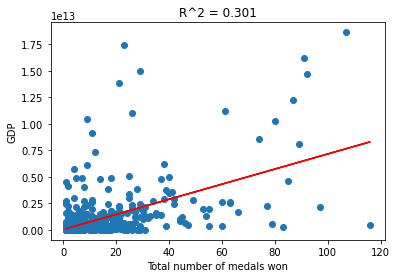

In [28]:
x = d['Medals_won']
p = d['GDP']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(x, p)  # perform linear regression
Y_pred = linear_regressor.predict(x)  # make predictions
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.301')
plt.xlabel('Total number of medals won')
plt.ylabel('GDP')
plt.show()

In [29]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[7.12126957e+10]]
the intercept is:  [3.77604283e+10]
the R^2 is: 0.30057360871339833


#### Medals won - Population size

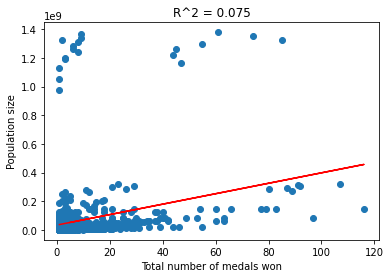

In [30]:
x = d['Medals_won']
p = d['Population_Size']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  
linear_regressor.fit(x, p)  
Y_pred = linear_regressor.predict(x)  
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.075')
plt.xlabel('Total number of medals won')
plt.ylabel('Population size')
plt.show()

In [31]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[3643630.60843405]]
the intercept is:  [33872774.28473325]
the R^2 is: 0.07520538315997538


#### Medals won - HDI

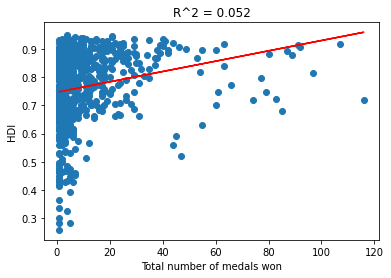

In [32]:
x = d['Medals_won']
p = d['HDI']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  
linear_regressor.fit(x, p)  
Y_pred = linear_regressor.predict(x)  
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.052')
plt.xlabel('Total number of medals won')
plt.ylabel('HDI')
plt.show()

In [33]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[0.00183433]]
the intercept is:  [0.74691589]
the R^2 is: 0.05240689700548151


Of course, this does not yield very interesting results. This happens because the entire dataframe includes the same countries multiple times, once for each time they participated in the olympic games.

### Beijing 2008

For this reason, we decided to apply the linear regression to one olympic game at a time. We start by looking at the Beijing games of 2008.

In [34]:
b = d[d['Year'] == 2008]
b

,Country_Year,Medals_won,Country,Year,GDP,Population_Size,HDI
5,Norway 2008,9,Norway,2008,4.625544e+11,4768212.0,0.938
9,Spain 2008,18,Spain,2008,1.635015e+12,45954106.0,0.856
11,Russia 2008,66,Russia,2008,1.660844e+12,142742350.0,0.774
12,Belarus 2008,16,Belarus,2008,6.076348e+10,9527985.0,0.774
13,France 2008,38,France,2008,2.923466e+12,64374990.0,0.869
...,...,...,...,...,...,...,...
602,Croatia 2008,5,Croatia,2008,7.048145e+10,4434508.0,0.805
604,Ecuador 2008,1,Ecuador,2008,6.176264e+10,14447562.0,0.711
619,Colombia 2008,2,Colombia,2008,2.439824e+11,44901544.0,0.720
626,Panama 2008,1,Panama,2008,2.452220e+10,3516268.0,0.755


#### Medals won - GDP

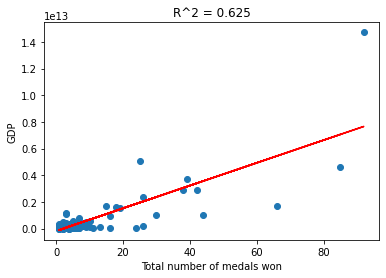

In [35]:
x = b['Medals_won']
p = b['GDP']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  
linear_regressor.fit(x, p)  
Y_pred = linear_regressor.predict(x)  
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.625')
plt.xlabel('Total number of medals won')
plt.ylabel('GDP')
plt.show()

In [36]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[8.52136376e+10]]
the intercept is:  [-1.83264464e+11]
the R^2 is: 0.6250596335038993


#### Medals won - Population size

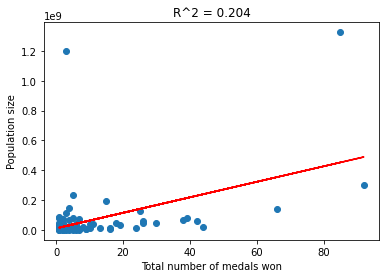

In [37]:
x = b['Medals_won']
p = b['Population_Size']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  
linear_regressor.fit(x, p)  
Y_pred = linear_regressor.predict(x)  
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.204')
plt.xlabel('Total number of medals won')
plt.ylabel('Population size')
plt.show()

In [38]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[5195169.04808747]]
the intercept is:  [10911962.66646458]
the R^2 is: 0.20382487429743723


#### Medals won - HDI

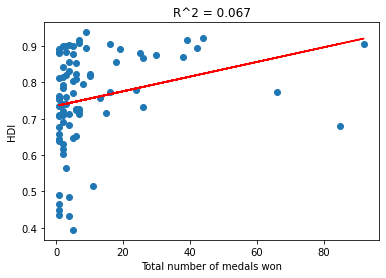

In [39]:
x = b['Medals_won']
p = b['HDI']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  
linear_regressor.fit(x, p)  
Y_pred = linear_regressor.predict(x)  
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.067')
plt.xlabel('Total number of medals won')
plt.ylabel('HDI')
plt.show()

In [40]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[0.00201679]]
the intercept is:  [0.73518124]
the R^2 is: 0.0671544746373629


Overall, this gave much better results. We can see how there is a pretty strong correlation between GDP and number of medals won, since R^2 is 0.625, while HDI and population size have much less of an impact, with $R^2$ < 0.2.

We now analyse another Olympic Game, to see if we get similar results.

### London 2012

In [41]:
l = d[d['Year'] == 2012]
l

,Country_Year,Medals_won,Country,Year,GDP,Population_Size,HDI
14,France 2012,34,France,2012,2.681416e+12,65659790.0,0.878
35,Canada 2012,18,Canada,2012,1.824289e+12,34750545.0,0.906
39,Russia 2012,77,Russia,2012,2.210257e+12,143201676.0,0.797
42,Egypt 2012,2,Egypt,2012,2.793728e+11,87813257.0,0.676
51,Netherlands 2012,19,Netherlands,2012,8.289468e+11,16754962.0,0.921
...,...,...,...,...,...,...,...
607,Portugal 2012,1,Portugal,2012,2.163682e+11,10514844.0,0.829
608,Latvia 2012,2,Latvia,2012,2.812000e+10,2034319.0,0.825
611,Thailand 2012,3,Thailand,2012,3.975600e+11,67843979.0,0.733
615,Bulgaria 2012,2,Bulgaria,2012,5.390303e+10,7305888.0,0.786


#### Medals won - GDP

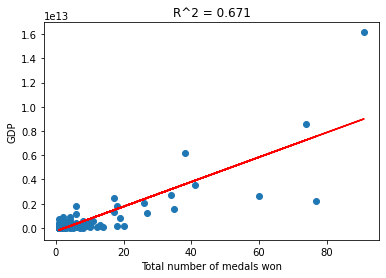

In [42]:
x = l['Medals_won']
p = l['GDP']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  
linear_regressor.fit(x, p)  
Y_pred = linear_regressor.predict(x)  
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.671')
plt.xlabel('Total number of medals won')
plt.ylabel('GDP')
plt.show()

In [43]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[1.01783561e+11]]
the intercept is:  [-2.69303123e+11]
the R^2 is: 0.6709874958827224


#### Medals won - Population size

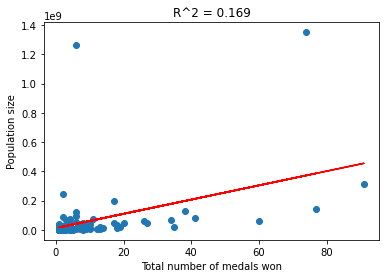

In [44]:
x = l['Medals_won']
p = l['Population_Size']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  
linear_regressor.fit(x, p)  
Y_pred = linear_regressor.predict(x)  
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.169')
plt.xlabel('Total number of medals won')
plt.ylabel('Population size')
plt.show()

In [45]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[4856114.53964468]]
the intercept is:  [13109991.18639519]
the R^2 is: 0.16928280295964604


#### Medals won - HDI

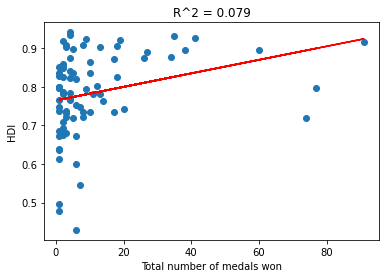

In [46]:
x = l['Medals_won']
p = l['HDI']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  
linear_regressor.fit(x, p)  
Y_pred = linear_regressor.predict(x)  
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.079')
plt.xlabel('Total number of medals won')
plt.ylabel('HDI')
plt.show()

In [47]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[0.00175295]]
the intercept is:  [0.76524824]
the R^2 is: 0.07855380181417149


In conclusion, we see that London 2012 has similar results to Beijing 2008. Since these are both summer games, we now analyse the situation for the winter games.

### Vancouver 2010

In [48]:
v = d[d['Year'] == 2010]
v.head()

,Country_Year,Medals_won,Country,Year,GDP,Population_Size,HDI
73,Germany 2010,25,Germany,2010,3.417095e+12,81776930.0,0.920
86,Canada 2010,24,Canada,2010,1.613464e+12,34005274.0,0.895
174,Switzerland 2010,9,Switzerland,2010,5.837830e+11,7824909.0,0.932
211,France 2010,11,France,2010,2.646837e+12,65027512.0,0.872
231,Japan 2010,4,Japan,2010,5.700098e+12,128070000.0,0.885


#### Medals won - GDP

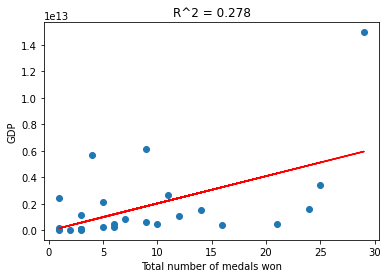

In [49]:
x = v['Medals_won']
p = v['GDP']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  
linear_regressor.fit(x, p) 
Y_pred = linear_regressor.predict(x)  
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.278')
plt.xlabel('Total number of medals won')
plt.ylabel('GDP')
plt.show()

In [50]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[2.06703254e+11]]
the intercept is:  [-4.927075e+10]
the R^2 is: 0.2782329846662027


#### Medals won - Population size

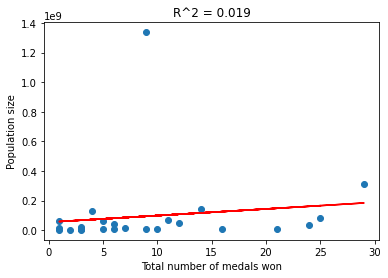

In [51]:
x = v['Medals_won']
p = v['Population_Size']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()  
linear_regressor.fit(x, p)  
Y_pred = linear_regressor.predict(x)
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.019')
plt.xlabel('Total number of medals won')
plt.ylabel('Population size')
plt.show()

In [52]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[4477881.18923623]]
the intercept is:  [53504473.53492143]
the R^2 is: 0.018814531085514452


#### Medals won - HDI

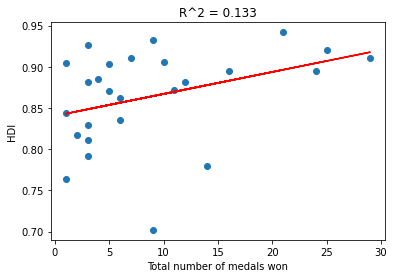

In [53]:
x = v['Medals_won']
p = v['HDI']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(x, p)
Y_pred = linear_regressor.predict(x)
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.133')
plt.xlabel('Total number of medals won')
plt.ylabel('HDI')
plt.show()

In [54]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[0.00266798]]
the intercept is:  [0.84043696]
the R^2 is: 0.1333013923658264


For the winter games the result are much less satisfactory. Wee see that the correlation between GDP and number of medals won drops to a $R^2$ of less than 0.3 and population size to less than 0.1, while the impact of HDI remains about the same (but it was already pretty low for the summer games).

We check these results by analysing another winter Olympic.

### Sochi 2014

In [55]:
s = d[d['Year'] == 2014]
s.head()

,Country_Year,Medals_won,Country,Year,GDP,Population_Size,HDI
0,Finland 2014,5,Finland,2014,2.726093e+11,5461512.0,0.918
25,USA 2014,23,USA,2014,1.739310e+13,318563456.0,0.915
64,UK 2014,4,UK,2014,3.022828e+12,64613160.0,0.918
87,Canada 2014,21,Canada,2014,1.792883e+12,35544564.0,0.914
145,Sweden 2014,13,Sweden,2014,5.738177e+11,9696110.0,0.929


#### Medals won - GDP

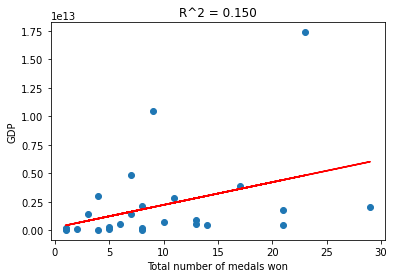

In [56]:
x = s['Medals_won']
p = s['GDP']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(x, p)
Y_pred = linear_regressor.predict(x)
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.150')
plt.xlabel('Total number of medals won')
plt.ylabel('GDP')
plt.show()

In [57]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[1.99685955e+11]]
the intercept is:  [2.32593566e+11]
the R^2 is: 0.15022225161499114


#### Medals won - Population size

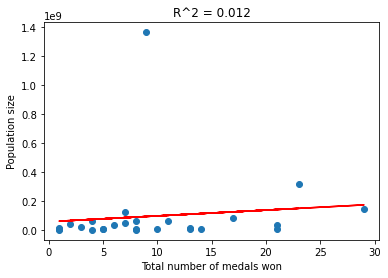

In [58]:
x = s['Medals_won']
p = s['Population_Size']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression() 
linear_regressor.fit(x, p)
Y_pred = linear_regressor.predict(x)
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.012')
plt.xlabel('Total number of medals won')
plt.ylabel('Population size')
plt.show()

In [59]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[3993057.02799721]]
the intercept is:  [58550620.46048849]
the R^2 is: 0.012326548172627794


#### Medals won - HDI

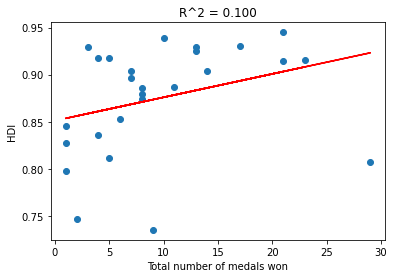

In [60]:
x = s['Medals_won']
p = s['HDI']
x=x.to_numpy()
p=p.to_numpy()
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(x, p)
Y_pred = linear_regressor.predict(x)
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('R^2 = 0.100')
plt.xlabel('Total number of medals won')
plt.ylabel('HDI')
plt.show()

In [61]:
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

the coefficient is:  [[0.00248522]]
the intercept is:  [0.85104653]
the R^2 is: 0.09962955266465834


Again, the final results are pretty similar. This difference in results between the summer and winter games makes sense considering that considering that countries with a colder climate tend to be better at winter sports, and those countries also happen to have pretty high GDPs and small populations, which in turn means there is not much of a correlation between those features and the number of medals won.

### Comparison between Linear Regression and Logistic Regression

In this last part, we compare the linear regression model with the logistic regression one, to see which one applies better to this particular problem. We chose the GDP and number of medals won in London 2012 as the field of comparison, since we already know it gives pretty good results for the linear regression ( $R^2$ = 0.671). We use the total sum of the residuals as a way of comparing the two regression models.

We start by recalling the linear regression model we have previously implemented, just with standardised number of medals and GDPs. This is done because the standardisation will be necessary for the logistic model, so they both need to have it otherwise comparison will not be possible.

In [62]:
stand_m =[]
for i,row in l.iterrows():
    x=int(l['Medals_won'][i])
    stand_m.append(x)
m_std = (stand_m - np.mean(stand_m)) / np.std(stand_m)

In [63]:
stand_gdp =[]
for i,row in l.iterrows():
    x=int(l['GDP'][i])
    stand_gdp.append(x)
gdp_std = (stand_gdp - np.mean(stand_gdp)) / np.std(stand_gdp)

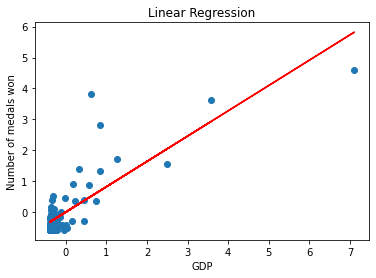

the coefficient is:  [[0.81913826]]
the intercept is:  [5.70345865e-17]
the R^2 is: 0.6709874958827078


In [64]:
x = gdp_std
p = m_std
x=x.reshape(-1,1)
p=p.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(x, p)
Y_pred = linear_regressor.predict(x) 
plt.scatter(x, p)
plt.plot(x, Y_pred, color='red')
plt.title('Linear Regression')
plt.xlabel('GDP')
plt.ylabel('Number of medals won')
plt.show()
print("the coefficient is: ",linear_regressor.coef_)
print("the intercept is: ",linear_regressor.intercept_)
print("the R^2 is:",linear_regressor.score(x,p))

In [65]:
tot_residuals = np.sum(np.power(p - Y_pred, 2))
tot_residuals

26.650012833500675

Now we move on to the logistic regression, for which we will again need the standardised GDP values. Instead, for the medals we implement a new binary list, which has value 1 for those countries that have won at least 15 medals and 0 for those that did not.

In [66]:
g=[]
for i,row in l.iterrows():
    x=int(l['GDP'][i])
    g.append(x)
g_std = (g - np.mean(g)) / np.std(g)

In [67]:
m=[]
x = 15
for i,row in l.iterrows():
    if l['Medals_won'][i]>x:
        m.append(1)
    else:
        m.append(0)

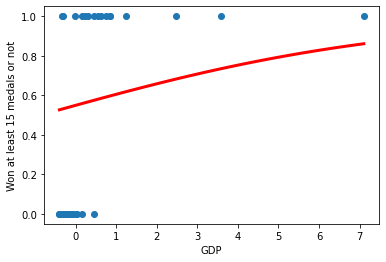

In [68]:
X = np.asarray(g_std)
y = m
X=X.reshape(-1,1)
plt.scatter(X.ravel(), y,zorder=20)
X_test = np.linspace(min(X), max(X), 81)
clf = LinearRegression()
clf.fit(X,y)
plt.xlabel('GDP')
plt.ylabel('Won at least 15 medals or not')
loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
loss_y = expit(X * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)

In [69]:
tot_residuals = np.sum(np.power(y - loss_y, 2))
print(tot_residuals)

21.04827279675492


So in conclusion, since we have total residuals equal to 26 for the linear regression model and 21 for the logistic regression one, the latter proves to be a better fit than the former.

Of course, it still makes sense for the previous analysis to be using the linear regression, as it yields more information for our set up.